In [124]:
import pandas as pd
import yfinance as yf
from math import nan, sqrt
import matplotlib.pyplot as plt

In [125]:
# https://finance.yahoo.com/news/stock-correlation-212133633.html?guccounter=1#:~:text=First%2C%20find%20the%20square%20of,each%20day%20in%20the%20period.
def corr_coef(dt1, dt2):
    return (dt1['Deviation']*dt2['Deviation']).sum()/(sqrt((dt1["Deviation"]**2).sum())*sqrt((dt2["Deviation"]**2).sum()))

In [126]:
#This function returns postive value if NSE is leading and negative if NASDAQ is leading
def lead_lag_rel(dt1, dt2, max_lag_time):
    cross_corr = [dt1.Close.corr(dt2.Close.shift(lag)) for lag in range(-max_lag_time, max_lag_time)]
    max_corr_index = cross_corr.index(max(cross_corr))

    return max(cross_corr), max_corr_index-max_lag_time

In [127]:
def calculate_keltner_channel(data, window=20, atr_multiplier=2):
    # Calculate True Range (TR)
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = data['High'] - data['Close'].shift(-1)
    data['L-PC'] = data['Low'] - data['Close'].shift(-1)
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    
    # Calculate Average True Range (ATR)
    data['ATR'] = data['TR'].ewm(window, adjust=False).mean()
    
    # Calculate Keltner Channel
    data['KCUpperBand'] = data['High'].ewm(window, adjust=False).mean() + atr_multiplier * data['ATR']
    data['KCLowerBand'] = data['Low'].ewm(window, adjust=False).mean() - atr_multiplier * data['ATR']
    data['KCMiddleBand'] = data['Close'].ewm(window, adjust=False).mean()
    
    return data[['KCUpperBand', 'KCMiddleBand', 'KCLowerBand']]

In [128]:

def calculate_bollinger_bands(data, window=20, num_std=2):
    # Calculate EMA and Standard Deviation
    rolling_mean = data['Close'].ewm(window, adjust=False).mean()
    rolling_std = data['Close'].ewm(window, adjust=False).std()
    
    # Calculate Bollinger Bands
    data['BUpperBand'] = rolling_mean + num_std * rolling_std
    data['BLowerBand'] = rolling_mean - num_std * rolling_std
    
    return data[['BUpperBand', 'BLowerBand']]

In [129]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate Exponential Moving Averages (EMA)
    ema_short = data['Close'].ewm(short_window, adjust=False).mean()
    ema_long = data['Close'].ewm(long_window, adjust=False).mean()
    
    # Calculate MACD Line
    macd_line = ema_short - ema_long
    
    # Calculate Signal Line
    signal_line = macd_line.ewm(signal_window, adjust=False).mean()
    
    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line
    
    data['MACD_Line'] = macd_line
    data['Signal_Line'] = signal_line
    data['MACD_Histogram'] = macd_histogram
    
    return data[['MACD_Line', 'Signal_Line', 'MACD_Histogram']]

In [130]:
data=yf.download("^IXIC", start='2010-01-01', end='2023-05-01')
dt1=pd.DataFrame(data)
data=yf.download("^NSEI", start='2010-01-01', end='2023-05-01')
dt2=pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [131]:
x_avg=dt1['Close'].mean()
dt1['Deviation']=dt1['Close']-x_avg
y_avg=dt2['Close'].mean()
dt2['Deviation']=dt2['Close']-y_avg
dt1

,Open,High,Low,Close,Adj Close,Volume,Deviation
Date,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,-4297.680510
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,-4297.390471
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,-4305.010344
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,-4306.050383
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000,-4288.930510
...,...,...,...,...,...,...,...
2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,5431.099763
2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,5193.059724
2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,5248.249177


In [132]:
corr_coef(dt1, dt2)

0.9142835706140554

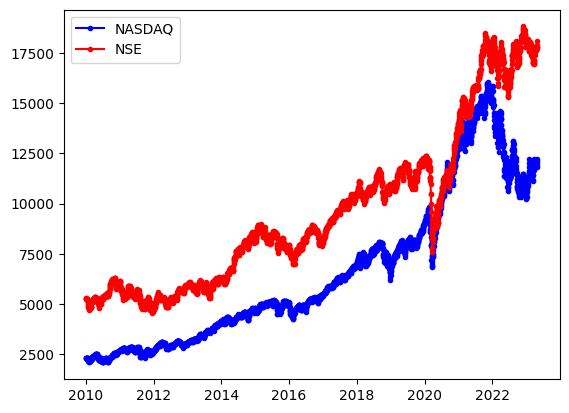

In [133]:
plt.plot(dt1.Close, '-b.', label='NASDAQ')
plt.plot(dt2.Close, '-r.', label='NSE')
plt.legend()

In [134]:
# tells us after a lag of how many days correlation maximises
# negative lag indicates NASDAQ is leading, positive indicates NSE is leading
lead_lag_rel(dt1, dt2, 200)

(0.9673330304839068, -150)

In [135]:
calculate_keltner_channel(dt1)

,KCUpperBand,KCMiddleBand,KCLowerBand
Date,,,
2010-01-04,2344.629883,2308.419922,2260.929932
2010-01-05,2344.883208,2308.433733,2260.857096
2010-01-06,2345.167357,2308.084036,2260.763885
2010-01-07,2344.609874,2307.701465,2260.397025
2010-01-08,2345.894169,2308.152344,2259.265267
...,...,...,...
2023-04-24,12321.330768,11863.514000,11381.563789
2023-04-25,12323.831246,11860.449531,11383.174498
2023-04-26,12319.735953,11860.159059,11391.748592


In [136]:
calculate_bollinger_bands(dt1)

,BUpperBand,BLowerBand
Date,,
2010-01-04,NaN,NaN
2010-01-05,2308.843910,2308.023556
2010-01-06,2315.610142,2300.557930
2010-01-07,2316.919766,2298.483164
2010-01-08,2318.882695,2297.421993
...,...,...
2023-04-24,12569.636042,11157.391958
2023-04-25,12550.112597,11170.786466
2023-04-26,12533.206434,11187.111683


In [137]:
calculate_macd(dt1)

,MACD_Line,Signal_Line,MACD_Histogram
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,0.011569,0.001157,0.010412
2010-01-06,-0.282108,-0.027170,-0.254938
2010-01-07,-0.583833,-0.082836,-0.500997
2010-01-08,-0.167526,-0.091305,-0.076221
...,...,...,...
2023-04-24,186.992016,175.308338,11.683678
2023-04-25,172.987823,175.076286,-2.088463
2023-04-26,162.248098,173.793468,-11.545369
